In [31]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline, EarlyStoppingCallback
from datasets import load_dataset, DatasetDict
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import login

In [2]:
#drive.mount('/content/drive')

Mounted at /content/drive


# Prepare the dataset

In [3]:
dataset = load_dataset("tanaos/synthetic-intent-classifier-dataset-v1")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 11489
    })
})


In [5]:
split1 = dataset['train'].train_test_split(test_size=0.2, seed=42)  # 80/20
split2 = split1['test'].train_test_split(test_size=0.5, seed=42)     # 10/10

datasets_final = DatasetDict({
    'train': split1['train'],
    'validation': split2['train'],
    'test': split2['test']
})

print(datasets_final)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9191
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1149
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1149
    })
})


In [6]:
dataset["train"][:10]

{'text': ['Hello, how are you?',
  "I'm doing great, thanks!",
  'Can you help me with something?',
  'Thanks for your assistance!',
  "I'm not happy with the service.",
  "You're doing a great job!",
  "I'm looking for a new restaurant to try.",
  'Can you speak in Spanish?',
  "That's not what I meant.",
  'Have a great day!'],
 'labels': [0, 3, 9, 2, 8, 7, 5, 11, 4, 1]}

In [7]:
datasets_final["train"].features["labels"]

Value('int64')

In [8]:
# label categories

id2label = {
    0: "greeting",
    1: "farewell",
    2: "thank_you",
    3: "affirmation",
    4: "negation",
    5: "small_talk",
    6: "bot_capabilities",
    7: "feedback_positive",
    8: "feedback_negative",
    9: "clarification",
    10: "suggestion",
    11: "language_change"
}

label2id = {v: k for k, v in id2label.items()}


# Load the base model

In [9]:
device = torch.device('cuda')

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels=12

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=12,
    id2label=id2label,
    label2id=label2id # adding label categories
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# sanity check
i = 0
ex = datasets_final["train"][i]

print("TEXT:", ex["text"])
print("LABEL ID:", ex["labels"])
print("LABEL NAME:", id2label[ex["labels"]])

TEXT: Greetings! It's nice to see you again.
LABEL ID: 0
LABEL NAME: greeting


# Tokenization

In [11]:
def preprocess_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

tokenized_datasets = datasets_final.map(
    preprocess_function, batched=True, remove_columns=['text']
)


Map:   0%|          | 0/1149 [00:00<?, ? examples/s]

In [12]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9191
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1149
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1149
    })
})

In [13]:
# sanity check
i = 0
example = tokenized_datasets["train"][i]
print(example)


{'labels': 0, 'input_ids': [101, 14806, 2015, 999, 2009, 1005, 1055, 3835, 2000, 2156, 2017, 2153, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# LoRA configuration

In [14]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # sequence classification
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 599,052 || all params: 110,090,520 || trainable%: 0.5441


# Training arguments

In [15]:
training_args = TrainingArguments(
    output_dir="./checkpoints/intent-lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
)


In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


# Data collator and trainer

In [17]:
data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)




/tmp/ipython-input-4077867807.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Train the model

In [18]:
trainer.train()

trainer.save_model("./best_model/intent-lora")
tokenizer.save_pretrained("./best_model/intent-lora")


Epoch,Training Loss,Validation Loss,Accuracy
1,0.386800,0.298147,0.912968
2,0.325300,0.240406,0.929504
3,0.187000,0.240598,0.930374
4,0.185400,0.233927,0.936466
5,0.205000,0.233613,0.935596
6,0.158000,0.245153,0.934726


('./best_model/intent-lora/tokenizer_config.json',
 './best_model/intent-lora/special_tokens_map.json',
 './best_model/intent-lora/vocab.txt',
 './best_model/intent-lora/added_tokens.json',
 './best_model/intent-lora/tokenizer.json')

In [19]:
# save the model on drive
#!cp -r ./best_model/intent-lora /content/drive/MyDrive/intent_detection_fine_tuning/

### Quick evaluation

In [30]:
model.eval()
text = "do you speak chinese?"
inputs = tokenizer(text, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_id = torch.argmax(outputs.logits, dim=-1).item()

pred_label = id2label[pred_id]

print("Predicted label:", pred_label)


Predicted label: language_change


# Test set evaluation

Classification Report:
                   precision    recall  f1-score   support

         greeting       0.94      0.94      0.94        95
         farewell       0.93      0.98      0.95        81
        thank_you       0.87      0.94      0.91        88
      affirmation       0.91      0.87      0.89       107
         negation       0.94      0.93      0.94       104
       small_talk       0.85      0.88      0.86       100
 bot_capabilities       0.92      0.94      0.93        93
feedback_positive       0.92      0.87      0.89       121
feedback_negative       0.92      0.95      0.94        76
    clarification       0.93      0.92      0.92        98
       suggestion       0.98      0.91      0.94        93
  language_change       0.98      0.99      0.98        93

         accuracy                           0.92      1149
        macro avg       0.92      0.93      0.92      1149
     weighted avg       0.92      0.92      0.92      1149



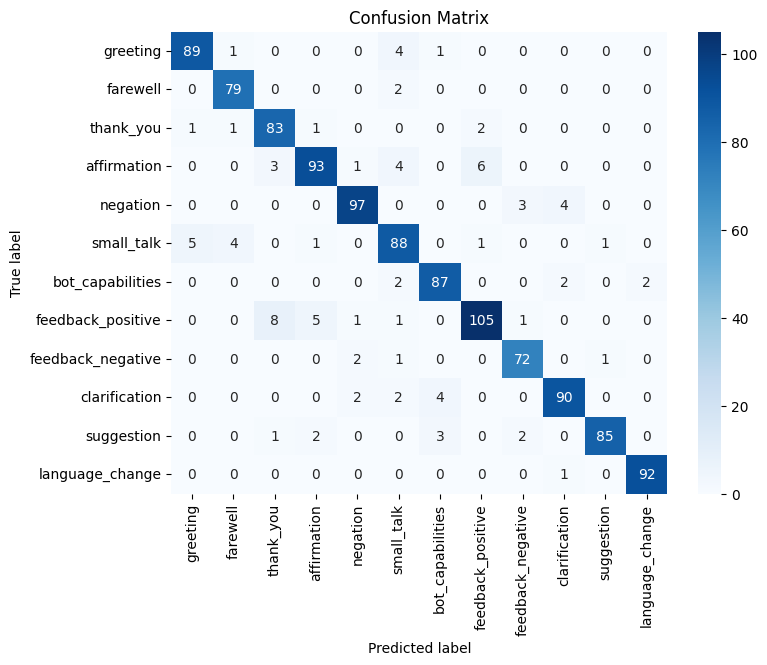

In [27]:
# categories
label_names = [
    "greeting",
    "farewell",
    "thank_you",
    "affirmation",
    "negation",
    "small_talk",
    "bot_capabilities",
    "feedback_positive",
    "feedback_negative",
    "clarification",
    "suggestion",
    "language_change"
]

# test set predictions
preds_output = trainer.predict(tokenized_datasets['test'])

y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()


# Push to Huggingface Hub

In [32]:
login()

### Merge the base model with the LoRA adapter

In [34]:
# load the base model
model_base = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=12,
    id2label=id2label,
    label2id=label2id
).to(device)

# load the adapter
adapter = PeftModel.from_pretrained(model_base, "./best_model/intent-lora")

# merge base model and adapter
model_merged = adapter.merge_and_unload()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
#push to hub
model_merged.push_to_hub("agataskrzyniarz/intent-detection-chatbot", use_auth_token=True)
tokenizer.push_to_hub("agataskrzyniarz/intent-detection-chatbot")

/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:917: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...q3n17j7/model.safetensors:   0%|          | 14.2kB /  438MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/agataskrzyniarz/intent-detection-chatbot/commit/28ea067796e00c32d4f1d5ac598afbcdd15490e6', commit_message='Upload tokenizer', commit_description='', oid='28ea067796e00c32d4f1d5ac598afbcdd15490e6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/agataskrzyniarz/intent-detection-chatbot', endpoint='https://huggingface.co', repo_type='model', repo_id='agataskrzyniarz/intent-detection-chatbot'), pr_revision=None, pr_num=None)